## Image-captioning model

### Overview

The code below trains an image captioning algorithm using a pre-trained vision and language transformer as well as the COCO dataset. The model uses the Microsoft Swin-Tiny-Patch4-Window7-224 and DistilGPT-2  pre-trained models as the encoder and decoder respectively.
The code implementation is done with the help of the following libraries/packages:
 - Transformers library from Hugging Face to implement the model.
 - PyTorch for tensor operations
 - PIL and torchvision libraries for image processing.


### Instructions to Run this notebook

To run this code on a local machine, follow these steps:

- Install the requirements listed in `requirements.txt`. Make sure to include the Transformers, datasets, scikit-learn, PIL, and PyTorch libraries/packages

- Download the COCO dataset and place it in the directory specified by the COCO_DIR variable.

Run the code in a Python environment that has access to a GPU. The code can be run in a Jupyter notebook or in a Python script. This code was run on MacBook M1.

In [2]:
from transformers import VisionEncoderDecoderModel, GPT2TokenizerFast, AutoFeatureExtractor, \
    TrainingArguments, Trainer
# todo look into what this data collector does
#from transformers import default_data_collator

import datasets
from PIL import Image
import torch
import torchvision.transforms as transforms
import ipywidgets as widgets
import numpy as np
import evaluate
from IPython.core.display_functions import display
import os
from torchview import draw_graph
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'

## Device


In [10]:
device_type = widgets.RadioButtons(
    options=['M1', 'Other'],
    value='M1',
    description='Select device',
    disabled=False
)
device_type

RadioButtons(description='Select device', options=('M1', 'Other'), value='M1')

In [11]:
# train on gpu
if device_type.value == 'M1':

    device = torch.device("mps")

else:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# test mps device support
torch.has_mps

True

## Model

Note that the cross-attention layers will be randomly initialized (see the warning message below) and hence they need to be fine-tuned on a downstream task, in thi case, image captioning generation.

In [12]:

#One of the main objectives is optimizing the cross-attention weights. How GPT connects to the encoders output,
model = VisionEncoderDecoderModel.from_encoder_decoder_pretrained(
    'microsoft/swin-tiny-patch4-window7-224',
    'distilgpt2'
).to(device)

Some weights of the model checkpoint at microsoft/swin-tiny-patch4-window7-224 were not used when initializing SwinModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing SwinModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing SwinModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at distilgpt2 and are newly initialized: ['transformer.h.2.crossattention.c_proj.bias', 'transformer.h.4.crossattention.masked_bias', 'transformer.h.3.crossattention.c_attn.weight', 'transformer.h.4.crossattention.bias', 'transformer.h.1.crossattention.bias', 'transformer.h.2.crossattention.c_attn.weight

### Encoder and Decoder pretrained Models

In [5]:
print(f'This model uses a pre-trained encoder of type {type(model.encoder)} and pre-trained decoder of type {type(model.decoder)}')

This model uses a pre-trained encoder of type <class 'transformers.models.swin.modeling_swin.SwinModel'> and pre-trained decoder of type <class 'transformers.models.gpt2.modeling_gpt2.GPT2LMHeadModel'>


### Number of Parameters

In [13]:
# Vit and GPT2 have 182,485,248 combined parameters. Swin version I am tuning here has fewer parameters
from torch import numel

combined_params = 0
for param in model.parameters():
    combined_params += numel(param)
    
print(f"Total number of parameters: {combined_params:,}")


Total number of parameters: 123,615,354


## Database
The image captioning algorithm is trained on the COCO dataset which consists of images and captions.

In [4]:
#Loads a small sample of the COCO database
# import datasets
# ds = datasets.load_dataset("ydshieh/coco_dataset_script", "2017", data_dir="./dummy_data/")
# ds

In [6]:
# COCO_DIR = input('Path to COCO dataset')

In [5]:
# Todo test if the image ids are repeated. the bumber of rows is given by the caption not by the images. The same image can have several descriptions, hence these
# several data points.
""""
1. Determine the number of unique ids
2. Determine the average captions per image

"""

#the datasets.load_dataset manages everything related to caching. So I have to use it.
COCO_DIR = '/Users/yesidcano/repos/image-captioning/data/coco'


#ds = datasets.load_dataset("ydshieh/coco_dataset_script", "2017",data_dir=COCO_DIR, cache_dir='/Users/yesidcano/repos/db_coco_cache')

# Load a slice of the database this https://huggingface.co/docs/datasets/loading to split dataset.

ds = datasets.load_dataset("ydshieh/coco_dataset_script", "2017",data_dir=COCO_DIR)
# ds = datasets.load_dataset("ydshieh/coco_dataset_script", "2017",data_dir=COCO_DIR, split="train[10:70]")
ds

Found cached dataset coco_dataset_script (/Users/yesidcano/.cache/huggingface/datasets/ydshieh___coco_dataset_script/2017-6b5176efb5303df4/0.0.0/e033205c0266a54c10be132f9264f2a39dcf893e798f6756d224b1ff5078998f)


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['image_id', 'caption_id', 'caption', 'height', 'width', 'file_name', 'coco_url', 'image_path'],
        num_rows: 591753
    })
    validation: Dataset({
        features: ['image_id', 'caption_id', 'caption', 'height', 'width', 'file_name', 'coco_url', 'image_path'],
        num_rows: 25014
    })
    test: Dataset({
        features: ['image_id', 'caption_id', 'caption', 'height', 'width', 'file_name', 'coco_url', 'image_path'],
        num_rows: 40670
    })
})

## Data processing

In [3]:
feature_extractor = AutoFeatureExtractor.from_pretrained("microsoft/swin-tiny-patch4-window7-224")
#gpt-2 tokenizer
tokenizer = GPT2TokenizerFast.from_pretrained('distilgpt2')
tokenizer.pad_token = tokenizer.eos_token



In [9]:
# Model config

model.config.pad_token = tokenizer.pad_token
model.config.pad_token_id = tokenizer.pad_token_id

model.config.decoder_start_token = tokenizer.bos_token
model.config.decoder_start_token_id = tokenizer.bos_token_id

In [10]:
feature_extractor

ViTFeatureExtractor {
  "do_normalize": true,
  "do_resize": true,
  "feature_extractor_type": "ViTFeatureExtractor",
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "resample": 3,
  "size": 224
}

In [11]:
# Uses fast tokenizer
tokenizer.is_fast

True

In [12]:
# Define the transforms to be applied to the images
transform = transforms.Compose([

    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

])


In [13]:


def preprocess_fn(examples):
    # Swin expects pixel_values instead of input_ids
    examples['pixel_values'] = [transform(Image.open(path).convert('RGB')) for path in examples['image_path']]
    # todo set this parameter to the average length of the captions
    tokenized = tokenizer(
        examples['caption'], padding='max_length', max_length=50, truncation=True
    )['input_ids']

    # the output captions
    examples['labels'] = [[l if l != tokenizer.pad_token_id else -100 for l in t] for t in tokenized]

    # delete unused keys
    del examples['image_path']
    del examples['caption']
    return examples


processed_dataset = ds.map(
    function=preprocess_fn,
    batched=True,
    batch_size=50,
    # remove_columns=['image_id', 'caption_id', 'caption', 'height', 'width', 'file_name', 'coco_url', 'image_path']

)

Loading cached processed dataset at /Users/yesidcano/.cache/huggingface/datasets/ydshieh___coco_dataset_script/2017-6b5176efb5303df4/0.0.0/e033205c0266a54c10be132f9264f2a39dcf893e798f6756d224b1ff5078998f/cache-3bbabcbb08e58764.arrow


In [14]:
# By default data are shuffled.
processed_dataset = processed_dataset.train_test_split(test_size=0.1)
processed_dataset

DatasetDict({
    train: Dataset({
        features: ['image_id', 'caption_id', 'height', 'width', 'file_name', 'coco_url', 'pixel_values', 'labels'],
        num_rows: 54
    })
    test: Dataset({
        features: ['image_id', 'caption_id', 'height', 'width', 'file_name', 'coco_url', 'pixel_values', 'labels'],
        num_rows: 6
    })
})

## Model's layers
Below a list of the encoder and decoder's layers respectively.

### Encoder Layers

In [15]:

for name, param in model.encoder.named_parameters():
    print(name)

embeddings.patch_embeddings.projection.weight
embeddings.patch_embeddings.projection.bias
embeddings.norm.weight
embeddings.norm.bias
encoder.layers.0.blocks.0.layernorm_before.weight
encoder.layers.0.blocks.0.layernorm_before.bias
encoder.layers.0.blocks.0.attention.self.relative_position_bias_table
encoder.layers.0.blocks.0.attention.self.query.weight
encoder.layers.0.blocks.0.attention.self.query.bias
encoder.layers.0.blocks.0.attention.self.key.weight
encoder.layers.0.blocks.0.attention.self.key.bias
encoder.layers.0.blocks.0.attention.self.value.weight
encoder.layers.0.blocks.0.attention.self.value.bias
encoder.layers.0.blocks.0.attention.output.dense.weight
encoder.layers.0.blocks.0.attention.output.dense.bias
encoder.layers.0.blocks.0.layernorm_after.weight
encoder.layers.0.blocks.0.layernorm_after.bias
encoder.layers.0.blocks.0.intermediate.dense.weight
encoder.layers.0.blocks.0.intermediate.dense.bias
encoder.layers.0.blocks.0.output.dense.weight
encoder.layers.0.blocks.0.outp

### Decoder's layers

In [16]:
for name, param in model.decoder.named_parameters():
    print(name)

transformer.wte.weight
transformer.wpe.weight
transformer.h.0.ln_1.weight
transformer.h.0.ln_1.bias
transformer.h.0.attn.c_attn.weight
transformer.h.0.attn.c_attn.bias
transformer.h.0.attn.c_proj.weight
transformer.h.0.attn.c_proj.bias
transformer.h.0.ln_2.weight
transformer.h.0.ln_2.bias
transformer.h.0.crossattention.c_attn.weight
transformer.h.0.crossattention.c_attn.bias
transformer.h.0.crossattention.q_attn.weight
transformer.h.0.crossattention.q_attn.bias
transformer.h.0.crossattention.c_proj.weight
transformer.h.0.crossattention.c_proj.bias
transformer.h.0.ln_cross_attn.weight
transformer.h.0.ln_cross_attn.bias
transformer.h.0.mlp.c_fc.weight
transformer.h.0.mlp.c_fc.bias
transformer.h.0.mlp.c_proj.weight
transformer.h.0.mlp.c_proj.bias
transformer.h.1.ln_1.weight
transformer.h.1.ln_1.bias
transformer.h.1.attn.c_attn.weight
transformer.h.1.attn.c_attn.bias
transformer.h.1.attn.c_proj.weight
transformer.h.1.attn.c_proj.bias
transformer.h.1.ln_2.weight
transformer.h.1.ln_2.bias
tr

### Freeze layers

In [17]:
# freeze layer of the encoder (Assuming that the model is already good at understanding images). Since all cross-attention weights need to be optimized
# I do not freeze any of the decoder layers.
for name, param in model.encoder.named_parameters():
    # freeze stage 1 and 2 of the Swin encoder.
    if 'encoder.layer.3' in name:
        break
    param.requires_grad = False

## Evaluation Metrics: Rouge and Bleu

- To decode using GPT's tokenizer I need to pass the token ids

In [18]:
rouge_metric = evaluate.load("rouge")
bleu_metric = evaluate.load("bleu")

In [19]:
def metrics(pred_labels):
    """
     Process the predicted captions and the labels (image captions) used to compute the metrics.
    :param pred_labels: set of predicted and target tokens. Type: transformers.trainer_utils.EvalPrediction
    :return: a dictionary with the resulting metric values.
    """
    results={}
    predictions = pred_labels.predictions[0]
    labels = pred_labels.label_ids

    #Convert the model's output into token IDs
    predictions = predictions.argmax(axis=-1)
    # predicted captions are decoded into strings using GPT-2 tokenizer
    decoded_predictions = tokenizer.batch_decode(predictions, skip_special_tokens=True)

    # the token ID -100 indicates the end of the sequence.
    # Replaces all -100 values with the id of the padding token in the tokeniezer
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    rouge = rouge_metric.compute(predictions= decoded_predictions,
                                         references= decoded_labels,
                                         use_stemmer=True) # returns a dict

    bleu = bleu_metric.compute(predictions=decoded_predictions,references=[[r] for r in decoded_labels])

    #Round values
    rouge = {k: round(v, 4) for k, v in rouge.items()}
    bleu = {k: [round(p, 4) for p in v ] if isinstance(v, list) else round(v, 4)  for k, v in bleu.items()}
    results.update(rouge)
    results.update((bleu))
    return results

## Training Procedure:

- The swin-gpt-2-image-captioning model is trained with the `Trainer` class from the transformers library.
- The arguments used for training are set via `TrainingArguments` class.
- The training is started by the `train ` method of the trainer class.

### Hyperparameters used by the `Trainer` for training and evaluation

In [20]:
training_arg = TrainingArguments(
    output_dir='../models/swin_image_captioning',  # dicts output
    overwrite_output_dir=True,
    num_train_epochs=2,
    per_device_train_batch_size=64,  # training batch size
    per_device_eval_batch_size=64,  # evaluation batch size
    load_best_model_at_end=True,
    log_level='info',
    logging_steps=50,
    evaluation_strategy='epoch', # set to 'steps' and the specify eval_steps=500,. This will give more data to plot
    save_strategy='epoch',
    use_mps_device=True, # use Apple Silicon
)



In [21]:

trainer = Trainer(
    model=model,
    args=training_arg,
    compute_metrics=metrics,
    train_dataset=processed_dataset['train'],
    eval_dataset=processed_dataset['test'],
    #data_collator=default_data_collator
)


In [22]:

trainer.evaluate()
print()

The following columns in the evaluation set don't have a corresponding argument in `VisionEncoderDecoderModel.forward` and have been ignored: coco_url, width, image_id, caption_id, file_name, height. If coco_url, width, image_id, caption_id, file_name, height are not expected by `VisionEncoderDecoderModel.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 6
  Batch size = 64


NotImplementedError: The operator 'aten::roll' is not currently implemented for the MPS device. If you want this op to be added in priority during the prototype phase of this feature, please comment on https://github.com/pytorch/pytorch/issues/77764. As a temporary fix, you can set the environment variable `PYTORCH_ENABLE_MPS_FALLBACK=1` to use the CPU as a fallback for this op. WARNING: this will be slower than running natively on MPS.

In [ ]:
# 4 epochs took 8 hours

trainer.train()

In [ ]:
print()
trainer.save_model()

In [ ]:
#need to save the tokenizer
tokenizer.save_pretrained('../models/swin_image_captioning')

In [4]:
# loading model and config from pretrained folder
finetuned_model = VisionEncoderDecoderModel.from_pretrained('../models/swin_image_captioning')

/Users/yesidcano/miniforge3/envs/torch-gpu/lib/python3.8/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1673856676759/work/aten/src/ATen/native/TensorShape.cpp:3454.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


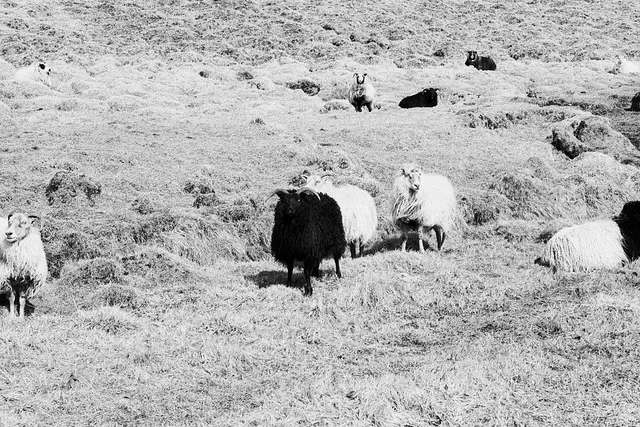

In [ ]:

"""
Make prediction using the pipeline library
look into wheater you can pass the feature_extractor as a parameter as well.
do_sample: returns multiple options
top_p: getting more confident less random, sharpen predictions

pretrained_generator = pipeline(
    'text-generation', model=model, tokenizer='gpt2',
    config={'max_length': 200, 'do_sample': True, 'top_p': 0.9, 'temperature': 0.7, 'top_k': 10}
)

"""

from IPython.core.display_functions import display





inference_transforms = transforms.Compose(
    [

    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]
)

# a helper function to caption images from the web or a file path
def generate_caption(m, path):

    img = Image.open(path).convert('RGB')
    img_transformed = inference_transforms(img).unsqueeze(0)
# tensor dimensions max_lenght X num_return_sequences, where ij == some_token_id
    model_output = m.generate(
        img_transformed,
        num_beams=3,
        max_length=15,
        early_stopping=True,
        do_sample=True,
        top_k=10,
        num_return_sequences=5,
    )
    # g is a tensor like this one: tensor([50256,    13,   198,   198,   198,   198,   198,   198,   198, 50256,
    #50256, 50256, 50256, 50256, 50256])
    captions = [tokenizer.decode(g, skip_special_tokens=True).strip() for g in model_output]
    #Show image
    display(img)
    return captions, model_output, img_transformed


captions, model_output, img_transformed = generate_caption(  # Out of sample photo
    finetuned_model, '../data/test_data/000000421195_test.jpg'
)



In [59]:
import onnx
import random
from onnx import helper, numpy_helper

In [39]:
from transformers import AutoModel

# Load the ViT model
vit_model = AutoModel.from_pretrained("microsoft/swin-tiny-patch4-window7-224")

# Load the GPT-2 model
gpt2_model = AutoModel.from_pretrained("gpt2")

Some weights of the model checkpoint at microsoft/swin-tiny-patch4-window7-224 were not used when initializing SwinModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing SwinModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing SwinModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [47]:
# Convert the ViT model to ONNX format
dummy_input = torch.randn(1, 3, 224, 224)
torch.onnx.export(vit_model, dummy_input, "vit_model.onnx", input_names=["input"], output_names=["output"])

# Convert the GPT-2 model to ONNX format
dummy_input = torch.randint(1, 1000, (1, 128))
torch.onnx.export(gpt2_model, dummy_input, "gpt2_model.onnx", input_names=["input"], output_names=["output"])


/Users/yesidcano/miniforge3/envs/torch-gpu/lib/python3.8/site-packages/transformers/models/swin/modeling_swin.py:303: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if num_channels != self.num_channels:
/Users/yesidcano/miniforge3/envs/torch-gpu/lib/python3.8/site-packages/transformers/models/swin/modeling_swin.py:293: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if width % self.patch_size[1] != 0:
/Users/yesidcano/miniforge3/envs/torch-gpu/lib/python3.8/site-packages/transformers/models/swin/modeling_swin.py:296: TracerWarning: Converting a tensor to 

========== Diagnostic Run torch.onnx.export version 2.0.0.dev20230116 ==========
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



/Users/yesidcano/miniforge3/envs/torch-gpu/lib/python3.8/site-packages/transformers/models/gpt2/modeling_gpt2.py:185: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  attn_weights = attn_weights / torch.tensor(
/Users/yesidcano/miniforge3/envs/torch-gpu/lib/python3.8/site-packages/transformers/models/gpt2/modeling_gpt2.py:185: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  attn_weights = attn_weights / torch.tensor(
/Users/yesidcano/miniforge3/envs/torch-gpu/lib/python3.8/site-packages/transformers/models/gpt2/modeling_gpt2.py:200: TracerWarning: torch.tensor results are registered as c

========== Diagnostic Run torch.onnx.export version 2.0.0.dev20230116 ==========
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



In [60]:
# Load the ViT model in ONNX format
vit_model = onnx.load("vit_model.onnx")

# Load the GPT-2 model in ONNX format
gpt2_model = onnx.load("gpt2_model.onnx")

In [ ]:
from mlprodict.onnxrt import OnnxInference

sess = OnnxInference(vit_model)
sess

In [40]:
# Define a dummy input tensor for the ViT model
vit_input = torch.randn(1, 3, 224, 224)

# Define a dummy input sequence for the GPT-2 model
gpt2_input = torch.randint(0, 50257, (1, 10))

In [45]:
# Set both models to evaluation mode
vit_model.eval()
gpt2_model.eval()

# Encode the input image using the ViT model
encoded_image = vit_model(vit_input)["last_hidden_state"]

# Decode the output from the ViT model using the GPT-2 model
decoded_output = gpt2_model(inputs_embeds=encoded_image)

In [58]:


# Load the ViT model in ONNX format
vit_model = onnx.load("vit_model.onnx")

# Load the GPT-2 model in ONNX format
gpt2_model = onnx.load("gpt2_model.onnx")

# Define a sequence of integers
seq = list(range(10000))

# Shuffle the sequence to get a random permutation
random.shuffle(seq)

# Take the first element of the shuffled sequence


# Define the input and output tensors of the combined model
input_tensor = helper.make_tensor_value_info(f"input{seq[0]}", onnx.TensorProto.FLOAT, [1, 3, 224, 224])
output_tensor = helper.make_tensor_value_info("output", onnx.TensorProto.FLOAT, [1, 128])

# Create a new ONNX graph
graph = helper.make_graph([], "ViT-GPT2 Graph", [input_tensor], [output_tensor])

# Add the ViT model to the graph
vit_node = helper.make_node("ViT", ["input_0_combined"], ["vit_output"])
for attr in vit_model.graph.node[0].attribute:
    vit_node.attribute.append(attr)
graph.node.extend([vit_node])

# Add the GPT-2 model to the graph
gpt2_node = helper.make_node("GPT2", ["vit_output"], ["output"])
for attr in gpt2_model.graph.node[0].attribute:
    if attr.name == "input":
        attr.name = "gpt2_input"
gpt2_node.input[0] = "gpt2_input"
graph.node.extend([gpt2_node])

# Add the input and output tensors to the graph
graph.input.extend([input_tensor])
graph.output.extend([output_tensor])

# Create the combined model
model = helper.make_model(graph)

# Save the combined model
onnx.checker.check_model(model)
onnx.save(model, "vit_gpt2_model.onnx")


ValidationError: Graph must be in single static assignment (SSA) form, however 'input146' has been used as graph input names multiple times.

In [44]:
decoded_output
print()

KeyboardInterrupt: 

In [46]:
# Export the combined model to ONNX format
onnx_model_path = "./vit_gpt2_model.onnx"
torch.onnx.export(
    (vit_input,),
    decoded_output.last_hidden_state.argmax(axis=-1),
    # decoded_output.logits,
    onnx_model_path,
    input_names=["input"],
    output_names=["output"],
    opset_version=12,
)

AttributeError: 'tuple' object has no attribute 'modules'